In [1]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import os 
import random
import experiment_helpers as eh
import utils
import bisect
from curlyBrace import curlyBrace
sns.set()

In [2]:
# SECOND WAVES HANDLES TWO PLOTS:
# - Probability of second-wave vs quarantine threshold
# - Width of second-wave vs width of first-wave vs quarantine threshold 

In [3]:
# Gather and plot VGraphs for BA10 + FB 
data = eh.gather_data()
keys = [_ for _ in data if _.endswith('bigiter')]
keys


['fbartist_bigiter', 'ba10_bigiter']

In [4]:
def get_second_wave_prop(name, second_wave=0.05):
    N = len(eh.parse_data_name(name))
    series = sorted(eh.group_by_qprop(data[name]).items())
    output = [] 
    for qprop, prop_list in series:
        Rs = [_ / N for _ in prop_list['final_R']] 
        live_Rs = [_ for _ in Rs if _ > (1 + second_wave) * qprop]
        output.append((qprop, len(live_Rs) / len(Rs)))
    return output


def get_medmed(arr):
    width = round(len(arr) **0.5)
    bins = []
    for i in range(width):
        bins.append(np.mean(arr[i * width : (i + 1)* width]))
    return (np.mean(bins), np.std(bins))

def get_second_wave_bernoulli(name, second_wave=0.05):
    N = len(eh.parse_data_name(name))
    series = sorted(eh.group_by_qprop(data[name]).items())
    output = [] 
    for qprop, prop_list in series:
        sublist = []
        for R in prop_list['final_R']:
            if R / N > (1 + second_wave) * qprop:
                sublist.append(1)
            else:
                sublist.append(0)
        output.append((qprop,) + get_medmed(sublist))
    return output


def plot_second_wave_prop(name, fig, ax, c, label=None, second_wave=0.05, alpha=1.0):
    output =get_second_wave_prop(name, second_wave=second_wave)
    ax.plot(*zip(*output), color=c, label=label, alpha=alpha)

    ax.legend()
    
    
def plot_second_wave_bernoulli(name, fig, ax, c, label=None, second_wave=0.05, alpha=1.0):
    bernoulli = get_second_wave_bernoulli(name, second_wave)
    ax.plot(*utils.select_mean(bernoulli), color=c, label=label)
    ax.fill_between(*utils.plotfill_trips(bernoulli), color=c, alpha=0.5)
    

Text(0.5, 1.0, 'Probability of Second Wave vs. Quarantine Threshold')

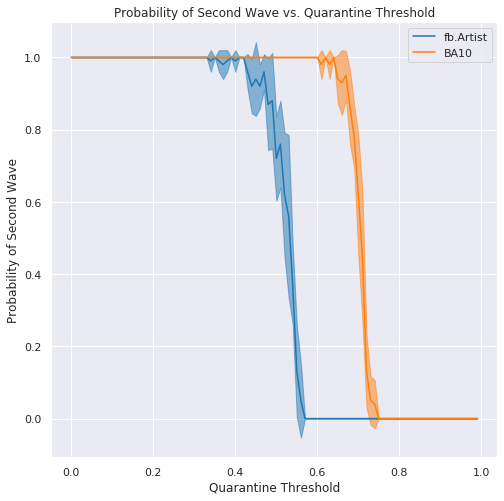

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
plot_second_wave_bernoulli(keys[0], fig, ax, c=utils.c(0), label='fb.Artist')
plot_second_wave_bernoulli(keys[1], fig, ax, c=utils.c(1), label='BA10')
ax.legend()
ax.set_xlabel('Quarantine Threshold')
ax.set_ylabel('Probability of Second Wave')
ax.set_title("Probability of Second Wave vs. Quarantine Threshold")

In [9]:
#### NOW PLOT: 
# Full width at half-maximum (relative), vs quarantine threshold 
def get_fwhm(G, tau, gamma, rho, num_iter=10):
    print()

def second_peak(tup, threshold_num):
    # Input is a tuple (for the run AFTER the quarantine) 
    # And the threshold is the NUMBER 
    return tup.R[-1] > threshold_num


def get_base_fwhm(G, tau, gamma, num_start, num_iter=10):
    tups = [Q.run_until_prop_IR(G, tau, gamma, num_start / len(G), float('inf'), 2.0)[1]
            for i in range(num_iter)]
    return np.mean([tup.get_peak_width() for tup in tups])
    
def get_live_second_waves(G, tau, gamma, num_start, prop, num_iter=10):
    # Collects the "peak width" for runs that 
    # Runs an SIR graph and collects the peak-width (in terms of time) 
    # G is the un-run G
    
    out_tups = []
    for i in range(num_iter):
        G2 = Q.run_until_prop_IR(G, tau, gamma, num_start / len(G), float('inf'), prop)[0]
        out_tup = Q.run_until_prop_IR(G2, tau, gamma, num_start / len(G2), float('inf'), 2.0)[1]
        if second_peak(out_tup, 200):
            out_tups.append(out_tup)
    return out_tups


def get_width_series(G, tau, gamma, num_start, proprange, num_iter=10):
    width_dict = {} 
    height_dict = {}
    for prop in proprange:
        print(prop)
        tups = get_live_second_waves(G, tau, gamma, num_start, prop, num_iter)
        width_dict[prop] = [_.get_peak_width() for _ in tups] 
        height_dict[prop] = [_.get_max_I() / len(G) for _ in tups]
        
    return width_dict,height_dict

In [13]:
keys[1]

'ba10_bigiter'

In [42]:
def group_peak_widths(name):
    data_series = data[name]
    peak_width_series = {}
    for doc in data_series:
        qprop = doc['quarantine_props']
        if qprop not in peak_width_series:
            peak_width_series[qprop] = [] 
        peak_width_series[qprop].append(doc['peak_widths'][-1])
    return peak_width_series

def plot_peak_widths(name, fig, ax, c, label=None):
    ba_peaks = group_peak_widths(name)
    base_width = np.mean(ba_peaks[0.0])
    ba_peak_plot = [(k, np.mean(v)/ base_width, np.std(v)/ base_width) for k, v in ba_peaks.items()]
    ax.plot(*utils.select_mean(ba_peak_plot), color=c, label=label)
    ax.fill_between(*utils.plotfill_trips(ba_peak_plot), color=c, alpha=0.5)
    

Text(0.5, 1.0, 'Second Wave Width vs. Quarantine Threshold')

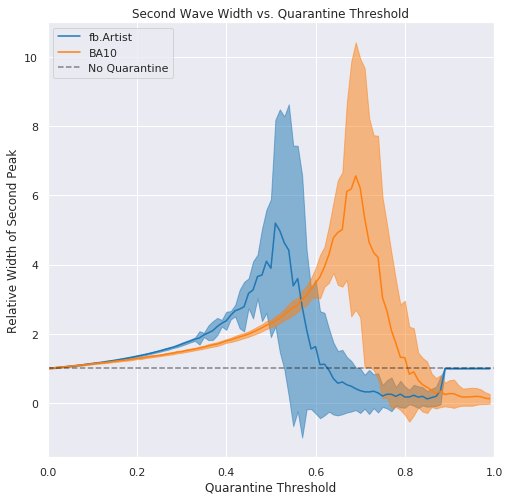

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
plot_peak_widths(keys[0], fig, ax, utils.c(0), label='fb.Artist')
plot_peak_widths(keys[1], fig, ax, utils.c(1), label='BA10')
ax.plot([0.0, 1.0], [1,1], 'k--', alpha=0.5, label='No Quarantine')
ax.set_xlabel('Quarantine Threshold')
ax.set_ylabel('Relative Width of Second Peak')
ax.set_xlim(0, 1)
ax.legend(loc='upper left')
ax.set_title("Second Wave Width vs. Quarantine Threshold")

In [22]:
ba_peak_plot = [(k, np.mean(v), np.std(v)) for k, v in ba_peaks.items()]

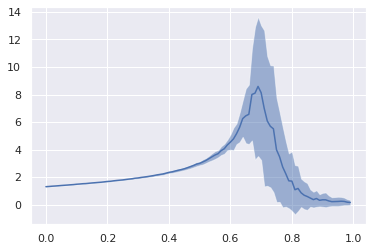

In [10]:
G = gg.ba_graph(10 ** 4, 10)
aG2=  Q.run_until_prop_IR(G,  0.5, 1, 10/len(G), float('inf'), 0.5)[0]
tup = [Q.run_until_prop_IR(G2, 0.5, 1.0, 10 / len(G), float('inf'), 2.0)[1] for _ in range(10)]

In [11]:
proprange = [_ / 10 for _ in range(8)]
proprange 


[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [12]:
out_dicts = get_width_series(G, 0.5, 1.0, 10, proprange)

0.0


KeyboardInterrupt: 

In [ ]:
hp, wp = [], []
for prop in proprange:
    wp.append((prop, np.mean(out_dicts[0][prop])))
    hp.append((prop, np.mean(out_dicts[1][prop])))
    
#plt.plot(*zip(*wp))


def plot_outdict(width_dict, height_dict, fig, ax):
    keys = sorted(width_dict.keys())
    height_trips = [(k, np.mean(height_dict[k]), np.std(height_dict[k])) 
                    for k in keys if len(height_dict[k]) >= 3]
    width_trips = [(k, np.mean(width_dict[k]), np.std(width_dict[k])) 
                    for k in keys if len(width_dict[k]) >= 3]
    
    #return height_trips, width_trips
    c1 = 'tab:red'
    ax.set_ylabel('Second Peak Rel. Width', color=c1)
    ax.plot(*utils.select_mean(width_trips), color=c1)
    ax.fill_between(*utils.plotfill_trips(width_trips), alpha=0.2, color=c1)
    ax.tick_params(axis='y', labelcolor=c1)

    
    ax2 = ax.twinx() 
    c2 = 'tab:blue'
    ax2.set_ylabel('Second Peak Height', color=c2)
    ax2.plot(*utils.select_mean(height_trips), color=c2)
    ax2.fill_between(*utils.plotfill_trips(height_trips), alpha=0.2, color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)

    fig.tight_layout() 
    plt.show()
    return fig, ax1, ax2



In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_outdict(*out_dicts, fig, ax)


### utils.select_mean(ht)